In [1]:
import pandas as pd
import pymde
import scipy as sp
import lang2vec.lang2vec as l2v
import numpy as np

In [2]:
import torch

In [3]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
languages = []
for lang in l2v.LANGUAGES:
    languages.append(str(lang))

In [5]:
l2v.LANGUAGES == l2v.available_languages()

True

In [6]:
feature_sets = l2v.FEATURE_SETS

In [7]:
feature_sets

['syntax_wals',
 'phonology_wals',
 'syntax_sswl',
 'syntax_ethnologue',
 'phonology_ethnologue',
 'inventory_ethnologue',
 'inventory_phoible_aa',
 'inventory_phoible_gm',
 'inventory_phoible_saphon',
 'inventory_phoible_spa',
 'inventory_phoible_ph',
 'inventory_phoible_ra',
 'inventory_phoible_upsid',
 'syntax_knn',
 'phonology_knn',
 'inventory_knn',
 'syntax_average',
 'phonology_average',
 'inventory_average',
 'fam',
 'id',
 'geo',
 'learned']

In [8]:
from iso639 import Lang
import iso639

In [9]:
feature_sets[-3]

'id'

In [10]:
features = feature_sets[:13]
features.append(feature_sets[-4])
features.append(feature_sets[-2])
features

['syntax_wals',
 'phonology_wals',
 'syntax_sswl',
 'syntax_ethnologue',
 'phonology_ethnologue',
 'inventory_ethnologue',
 'inventory_phoible_aa',
 'inventory_phoible_gm',
 'inventory_phoible_saphon',
 'inventory_phoible_spa',
 'inventory_phoible_ph',
 'inventory_phoible_ra',
 'inventory_phoible_upsid',
 'fam',
 'geo']

In [11]:
features = l2v.get_features(languages, features)

In [12]:
for key, items in features.items():
    for i, item in enumerate(items):
        if item == '--':
            features[key][i] = 0

In [13]:
del_keys = []
for key, items in features.items():
    if items == [0] * len(items):
        del_keys.append(key)

In [14]:
for key in del_keys:
    del features[key]

In [15]:
lang_names = []
invalid = []
for key in features:
    try:
        lang = Lang(key)
        lang_names.append(lang.name)
    except iso639.exceptions.DeprecatedLanguageValue as e:
        err = str(e)
        index_1 = err.find('for')
        index_2 = err.find('is deprecated')
        lang = err[index_1:index_2].strip()
        lang_names.append(lang)
    except iso639.exceptions.InvalidLanguageValue as e:
        invalid.append(key)

In [16]:
for key in invalid:
    del features[key]

In [17]:
features_array = np.array(list(features.values()))
len(features_array)

4000

In [18]:
adjacency_matrix = sp.sparse.csr_matrix(np.array(list(features.values())))

In [20]:
graph = pymde.preprocess.k_nearest_neighbors(adjacency_matrix, k=100)

Sep 23 07:51:52 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Sep 23 07:51:52 PM: The following items have duplicates [ 243 1113 1761 3770]


In [21]:
mde = pymde.preserve_neighbors(graph, device='xpu:0', embedding_dim=3)

c:\Users\dania\anaconda3\envs\seamt\Lib\site-packages\pymde\util.py:164: UserWarning: Aten Op fallback from XPU to CPU happends. This may have performance implications. If need debug the fallback ops please set environment variable `PYTORCH_DEBUG_XPU_FALLBACK=1`  (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\build\xpu\ATen\RegisterXPU_0.cpp:54528.)
  U, _, Vh = torch.linalg.svd(X, full_matrices=False)


In [22]:
edges = graph.edges
edges = edges.to('xpu')
weights = graph.weights
weights = weights.to('xpu')

In [23]:
import torch

In [24]:
embedding = mde.embed(verbose=True, max_iter=2000, print_every=50)

Sep 23 07:52:05 PM: Fitting a centered embedding into R^3, for a graph with 4000 items and 111438 edges.
Sep 23 07:52:05 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Sep 23 07:52:06 PM: iteration 0000 | distortion 0.294768 | residual norm 0.0636471 | step length 0.428906 | percent change 0.0249202
Sep 23 07:52:09 PM: iteration 0050 | distortion 0.186147 | residual norm 0.000426621 | step length 1 | percent change 1.10765
Sep 23 07:52:12 PM: iteration 0100 | distortion 0.184343 | residual norm 0.000222337 | step length 1 | percent change 0.205125
Sep 23 07:52:15 PM: iteration 0150 | distortion 0.183693 | residual norm 0.000104315 | step length 1 | percent change 0.286201
Sep 23 07:52:18 PM: iteration 0200 | distortion 0.183534 | residual norm 7.59571e-05 | step length 1 | percent change 0.244064
Sep 23 07:52:22 PM: iteration 0250 | distortion 0.183452 | residual norm 4.7864e-05 | step length 1 | percent change 0.201976
Sep 23 07:52:24 PM: iteration 0300 | di

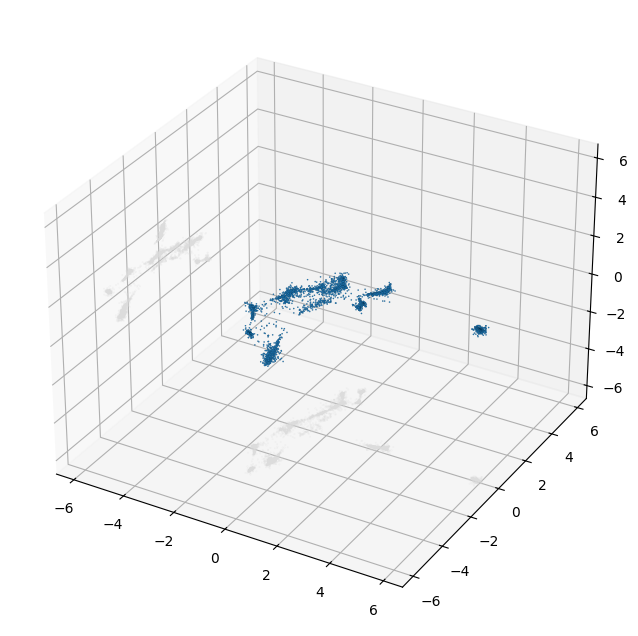

In [25]:
import matplotlib.pyplot as plt
mde.plot()
plt.show()

In [26]:
import emblaze

In [27]:
from emblaze.utils import Field, ProjectionTechnique

In [28]:
X = embedding.to('cpu')

In [29]:
emb = emblaze.Embedding({Field.POSITION: X, Field.COLOR: lang_names})

In [30]:
emb.compute_neighbors(metric='cosine')

In [31]:
variants = emblaze.EmbeddingSet([emb.project(method=ProjectionTechnique.UMAP) for _ in range(10)])

In [32]:
variants.compute_neighbors(metric='euclidean')

In [33]:
thumbnails = emblaze.TextThumbnails(lang_names)

In [34]:
for emb in variants.embeddings:
    emb.set_field(Field.NAME, lang_names)

In [ ]:
w = emblaze.Viewer(embeddings=variants, thumbnails=thumbnails)
w

Viewer(colorScheme='tableau', data={'data': [{'_format': 'compressed', '_idtype': 'u2', '_length': 4000, 'ids'…

: 

In [35]:
w.save_comparison('visualisation_v1.json')